In [101]:
# This is an implementation of imp step based on Gorte paper 

In [2]:
# load dependencies'
import concurrent.futures
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import osmnx as ox
import networkx as nx
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
from urllib.parse import urljoin
from shapely.geometry import Point, LineString, Polygon
import pyproj 
import mm_utils
from function_util import *
from IMP import IMP
from FIS1 import FIS1

# Project data into UTM 32 

In [3]:
gdf_utm = pd.read_pickle('gdf_utm.pkl')
edges_utm = pd.read_pickle('edges_utm.pkl')


# Project trajectory into utm 31

# Perform IMP 

C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Pl

['no edeges intersects with error bound at iteration number', 1]
['no edeges intersects with error bound at iteration number', 2]
['no edeges intersects with error bound at iteration number', 3]
['no edeges intersects with error bound at iteration number', 4]
['no edeges intersects with error bound at iteration number', 5]
['no edeges intersects with error bound at iteration number', 6]
['no edeges intersects with error bound at iteration number', 7]


C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Pl

['no edeges intersects with error bound at iteration number', 8]
['no edeges intersects with error bound at iteration number', 9]
['no edeges intersects with error bound at iteration number', 10]
['no edeges intersects with error bound at iteration number', 11]
['edges found at iteration number', 12]


C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\scipy\

['edges found at iteration number', 13]
['stopping at position', 12]


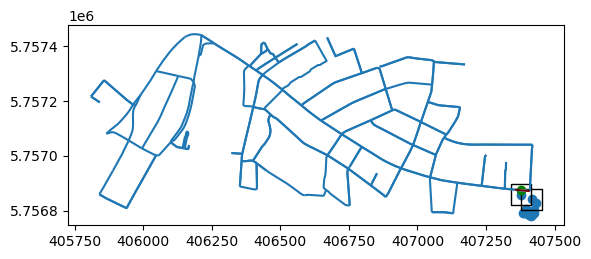

In [4]:
pt_index, curr_edge = IMP(gdf_utm, edges_utm, 2, plot = True)

In [5]:
pt_index

12

In [6]:
curr_edge

,,,osmid,lanes,ref,name,highway,maxspeed,oneway,reversed,length,geometry,access,width,lon_lat,str_id,perp_dist,lon_lat_pair,edge_heading,heading_error
u,v,key,,,,,,,,,,,,,,,,,,
135535395,53200191,0,"[673214248, 234046511]",3,L 793,Wolbecker Straße,secondary,50,False,False,54.889,"LINESTRING (407409.636 5756871.844, 407400.559...",NaN,NaN,"LINESTRING (7.65261 51.95483, 7.65247 51.95483...","673214248,234046511",15.797749,"[(7.6526059, 51.9548309), (7.6524737, 51.95483...",273.998415,23.501585


# Plot Result

In [5]:
%matplotlib tk
# This is how we  visualize edges and error bound 

# find which edges is selected at time point
# find index of the edge id
loc = np.where(edges_utm["str_id"] == conc(edge_link[count]))

# find the last two position for IMP
poly_1 = err_polygon(curr_pos_list[count + iter - 2], err_size)
poly_2 = err_polygon(curr_pos_list[count + iter - 3], err_size)

#Save selected edge 
answer_loc = edges_utm.iloc[loc]

# plotting edges and starting point together 
f, ax = plt.subplots()

# location for all point
#locs_utm.plot(ax=ax)
point_locs = gdf_utm['geometry'].to_frame()
point_locs.iloc[0:(iter), :].plot(ax = ax)

#err coord 
# better if we just take location at the last and use error bound function 
poly_1.plot(ax=ax, facecolor="none")
poly_2.plot(ax=ax, facecolor="none")

# this plot all the road system 
edges_utm.plot(ax=ax)

# this plot the selected edge at time point 
answer_loc.plot(ax=ax, cmap = "Reds")

# matched point plot
matched_point.plot(ax = ax, color = "Green")

#print(intersects['index_right'])

<Axes: >

In [107]:
# to convert current position list from list to dataframe 
# pd.concat(curr_pos_list)['geometry']

0     POINT (819633.5807833129 5766179.609685688)
1     POINT (819622.5537502016 5766163.388639316)
2     POINT (819626.0013702163 5766163.385287559)
3     POINT (819632.6479374802 5766162.987711843)
4     POINT (819643.6418708554 5766158.897275649)
5     POINT (819649.3764079262 5766159.465666196)
6     POINT (819653.2070335334 5766153.690892602)
7      POINT (819656.3996371442 5766158.78538911)
8      POINT (819660.8047981295 5766167.51956023)
9     POINT (819661.9277071179 5766176.194010578)
10     POINT (819666.404511811 5766203.248064032)
11     POINT (819649.308062795 5766214.664886044)
12    POINT (819609.7343499986 5766228.984348884)
Name: geometry, dtype: object

In [8]:
# save saved edge location for SMP1 debugging purposes
answer_loc.to_pickle('current_edge.pkl')

# Debugging 

In [20]:
#---------------------------------------------------------------------------
# n i s the number of same points detected to edges needed to stop IMP
# function return index of location noted as starting point. 
# initialization for IMP
count = 0 
same_link = 0
stop_iter = False
iter = 0
err_size = 38
n = 2

# saving answer for debugging purposes 
# edge_link saves all the candidate link name for each iteration 
# final answer is stored in the edge_link variable 
edge_link = []
# store fixed points : points projection to edge
fixed_points = []
# fis_res saves the output of FIS algorithm at every iteration 
fis_res = []
# HE_iter saves the heading error values for each candidate edge at any given iteration 
HE_iter = [] 
#curr_pos
curr_pos_list = []
# save candidate link name each iteration  
candidate_link_res = []

while stop_iter == False :
    # extract current location at given iteration 
    curr_loc = gdf_utm.iloc[[iter]]
    # save the iteration current position as a list
    curr_pos_list.append(curr_loc)

    #-----------------------------------------------------------------------
    # input should be location and error size 
    # create rectangular polygon 
    err_poly = err_polygon(curr_loc, err_size)

    # to plot error polygon for debugging
    # err_poly.plot()

    #---------------------------------------------------------------------------

    # Check for intersection and containment using geopandas
    intersects = gpd.sjoin(err_poly, edges_utm, op='intersects')
    contains = gpd.sjoin(err_poly, edges_utm, op='contains')

    if (len(intersects) + len(contains)) <=0:
        print(['no edeges intersects with error bound at iteration number', iter + 1])
    else:    
        # perform IMP only when there is edge intersects with error bound
        print(['edges found at iteration number', iter + 1])

        # extract index from edges that intersect with error polygon 
        int_index = intersects[['index_right0', 'index_right1', 'index_right2']]
        # extract index from edges that contained in the error polygon 
        cont_index = contains[['index_right0', 'index_right1', 'index_right2']]

        # merge index
        index = pd.concat([int_index, cont_index])
        # drop duplicate
        index = index.drop_duplicates()

        # initialize candidate edges 
        appended_edge = []

        # extract candidate eges  
        for i in range(len(index)):
            edge_list = (index['index_right0'].iloc[i], index['index_right1'].iloc[i], 0 )
            appended_edge.append(edge_list)

        candidate_link = edges_utm.loc[appended_edge]

        #save candidate link name 
        candidate_link_res.append(candidate_link['osmid'])

        # calculate perpendicular distance 
        # initialize list that hold perpendicular distance between points and edges
        p_dist = []

        # calculate perpendicular distance between current point and 
        for i in range(len(candidate_link)):
            p_dist.append(candidate_link['geometry'].iloc[i].distance(curr_loc['geometry']).iloc[0])

        # attach perpendicular distance to candidate link 
        candidate_link["perp_dist"] = p_dist

        # print(candidate_link)

        # calculate heading error
        # convert lat lon into tupple coordinate 
        candidate_link['lon_lat_pair'] = candidate_link.lon_lat.apply(lambda geom: list(geom.coords))

        # calculate bearing frome start and end node for each candidate link (see notes below)
        bearing_raw = candidate_link['lon_lat_pair'].apply(edge_bearing)

        # convert bearing from -pi, pi to 0, 2pi range
        candidate_link['edge_heading'] = bearing_raw.apply(conv_angle)

        # heading error = abs(gps heading - edge bearing)
        candidate_link['heading_error'] = abs(candidate_link['edge_heading'] - gdf_utm['GPS Bearing'].iloc[iter])

        # initialize input for FIS
        PD = candidate_link['perp_dist']
        HE = candidate_link['heading_error']
        speed = np.repeat(gdf_utm['speed_mps'][iter]/ 3.6, len(candidate_link))
        hdop = np.repeat(gdf_utm['GPS HDOP'][iter], len(candidate_link))

        # save HE value every iter 
        HE_iter.append(HE)
        # rearrange new data to the input of fis1  
        new_data = np.array([speed, HE, PD, hdop]).T

        # calculating FIS
        pred =[]
        for i in range(len(new_data)):
            pred.append(FIS1(new_data[i,:], plot = False))

        # print(pred)
        # save fis result 
        fis_res.append(pred)

        # pick candidate link based on 
        index = pred.index(max(pred))

        edge_link.append(candidate_link['osmid'].iloc[index])

        # check if the current position and previous position is in the same edge
        if count > 0:
            if edge_link[count] == edge_link[count - 1]:
                same_link = same_link + 1
            else:
                same_link = 0

        # check to stop the for loop if n points belong to the same edge
        if same_link == (n - 1):
            print(['stopping at position',iter])
            stop_iter = True
            # find projection point 
            matched_link = candidate_link.iloc[[index]]
        else:
            count = count + 1

    #update iteration 
    iter = iter + 1


        


C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Pl

['no edeges intersects with error bound at iteration number', 1]
['no edeges intersects with error bound at iteration number', 2]
['no edeges intersects with error bound at iteration number', 3]
['no edeges intersects with error bound at iteration number', 4]
['no edeges intersects with error bound at iteration number', 5]
['no edeges intersects with error bound at iteration number', 6]
['no edeges intersects with error bound at iteration number', 7]
['no edeges intersects with error bound at iteration number', 8]


C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Pl

['no edeges intersects with error bound at iteration number', 9]
['no edeges intersects with error bound at iteration number', 10]
['no edeges intersects with error bound at iteration number', 11]
['edges found at iteration number', 12]
['edges found at iteration number', 13]
['stopping at position', 12]


C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [17]:
matched_link

,,,osmid,lanes,ref,name,highway,maxspeed,oneway,reversed,length,geometry,access,width,lon_lat,str_id,perp_dist,lon_lat_pair,edge_heading,heading_error
u,v,key,,,,,,,,,,,,,,,,,,
135535395,53200191,0,"[673214248, 234046511]",3,L 793,Wolbecker Straße,secondary,50,False,False,54.889,"LINESTRING (407409.636 5756871.844, 407400.559...",NaN,NaN,"LINESTRING (7.65261 51.95483, 7.65247 51.95483...","673214248,234046511",15.797749,"[(7.6526059, 51.9548309), (7.6524737, 51.95483...",273.998415,23.501585


In [19]:
matched_point

,geometry
0,POINT (407378.832 5756874.410)


In [14]:
%matplotlib tk
# This is how we  visualize edges and error bound 
# find which edges is selected at time point
# find index of the edge id
loc = np.where(edges_utm["str_id"] == conc(edge_link[count]))

# find the last two position for IMP
poly_1 = err_polygon(curr_pos_list[count + iter - 2], err_size)
poly_2 = err_polygon(curr_pos_list[count + iter - 3], err_size)

#Save selected edge 
answer_loc = edges_utm.iloc[loc]

# plotting edges and starting point together 
f, ax = plt.subplots()

# location for all point
#locs_utm.plot(ax=ax)
point_locs = gdf_utm['geometry'].to_frame()
point_locs.iloc[0:(iter), :].plot(ax = ax)

#err coord 
# better if we just take location at the last and use error bound function 
poly_1.plot(ax=ax, facecolor="none")
poly_2.plot(ax=ax, facecolor="none")

# this plot all the road system 
edges_utm.plot(ax=ax)

# this plot the selected edge at time point 
answer_loc.plot(ax=ax, cmap = "Reds")

# matched point plot
matched_point.plot(ax = ax, color = "Green")

<Axes: >

In [9]:
print(candidate_link['geometry'].iloc[0])

LINESTRING (819585.7050122877 5766245.100258521, 819590.5220386329 5766245.029529899, 819603.4127470632 5766244.851285359, 819618.4301928144 5766244.731255461, 819621.3001876773 5766244.703163195, 819626.8358634054 5766244.499981426, 819631.704009773 5766244.599953373, 819640.8071610486 5766244.781650782)


In [11]:
print(candidate_link['lon_lat_pair'].iloc[0])

[(7.651807, 51.9548654), (7.6518768, 51.954862), (7.6520636, 51.954853), (7.6522813, 51.9548433), (7.6523229, 51.9548414), (7.652403, 51.9548364), (7.6524737, 51.9548345), (7.6526059, 51.9548309)]
